# school 컬럼 복구 + 자잘한 md 정리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.DataFrame(pd.read_csv('../data/student-mat.csv', sep=';'))

### 숫자형 아닌 컬럼을 숫자형으로 바꾸거나 drop해야 함

In [3]:
# 숫자형이 아닌 속성들 확인
# 어떤 값들로 이루어져 있는진 사이트의 데이터 설명참조함
df.select_dtypes(include=['object']).nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

### Str타입인 address를 &rarr; boolean타입인 fromCity으로 변환

In [4]:
df['address'].unique()

array(['U', 'R'], dtype=object)

In [5]:
# fromCity 컬럼 추가
df.insert(1, "fromCity", df['address'].apply(lambda x: 1 if x == 'U' else 0))

# address 컬럼 삭제
df.drop(columns=['address'], inplace=True)

df.head()

,school,fromCity,sex,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,1,F,18,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,1,F,17,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,1,F,15,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,1,F,15,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,1,F,16,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### ~~도시학교(GP)와 시골학교(MS) 간 인원수 차이가 큼 &rarr; 시골학교(MS)인 학생들 제거 후 필요없어진 school 컬럼도 제거~~
- ~~한 데이터셋으로 두면 데이터 편향 생김~~
- ~~언더 or 오버 샘플링 미고려~~
- ~~각 학교별 성격이 다름. 시험 채점 방식도 다를 수 있음.~~
### 필요하다 싶으면 각자 알아서 drop해서 쓰면 되니까 전처리 단계에선 유지하기

In [6]:
df['school'].unique()

array(['GP', 'MS'], dtype=object)

In [7]:
# 학교별로 나누고 school 컬럼
# gp_df = df[df['school'] == 'GP']
# ms_df = df[df['school'] == 'MS']
# gp_df = gp_df.drop(columns=['school'])
# ms_df = ms_df.drop(columns=['school'])

print(f'총합: {len(df)}, 도시학교: {len(df[df['school'] == 'GP'])}, 시골학교: {len(df[df['school'] == 'MS'])}')

총합: 395, 도시학교: 349, 시골학교: 46


In [8]:
print(f'도시학교: {df[df['school'] == 'GP']['fromCity'].value_counts()}, \n\n시골학교: {df[df['school'] == 'MS']['fromCity'].value_counts()}')

도시학교: fromCity
1    286
0     63
Name: count, dtype: int64, 

시골학교: fromCity
0    25
1    21
Name: count, dtype: int64


### Str타입인 성별을 numeric으로

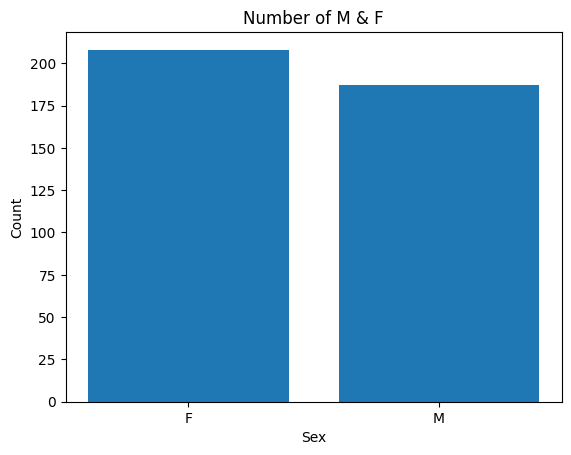

In [9]:
# 막대그래프로 표시
counts = df['sex'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Number of M & F")
plt.show()

##### female은 0 male은 1임

In [10]:
from sklearn.preprocessing import LabelEncoder
print(df['sex'][0])
# str 성별 -> numeric 성별
encoder = LabelEncoder()
df['sex'] = encoder.fit_transform(df['sex'])
df['sex'].dtypes, df['sex'][0]


F


(dtype('int64'), np.int64(0))

### famsize는 가족구성원이 3명보다 많으면 GT3, 적으면 LE3 임 &rarr; T/F인 famMore3 로 변환 

##### famisize를 숫자형으로 바꾸고 컬럼명을 famMore3로 rename

In [11]:
df['famsize'] = df['famsize'].apply(lambda x: 1 if x == 'GT3' else 0)
df.rename(columns={'famsize': 'famMore3'}, inplace=True)
df.head(2)

,school,fromCity,sex,age,famMore3,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,1,0,18,1,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,1,0,17,1,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6


### Pstatus컬럼의 A는 부모랑 떨어져 사는거, T는 같이 사는걸 의미 &rarr; liveTogether로 바꿈

In [12]:
df['Pstatus'] = df['Pstatus'].apply(lambda x: 1 if x == 'T' else 0)
df.rename(columns={'Pstatus': 'liveTogether'}, inplace=True)
df['liveTogether'].head()

0    0
1    1
2    1
3    1
4    1
Name: liveTogether, dtype: int64

### guardian는 mother, father, other. mother과 father 중 하나만 골라야해서 의미가 모호함(이혼가정인지 모름) &rarr; guardian 컬럼은 제거

In [13]:
print(df['guardian'].value_counts())

df['guardian'] = df['guardian'].apply(lambda x: 1 if x == 'other' else 0)
df.rename(columns={'guardian': 'noParent'}, inplace=True)

guardian
mother    273
father     90
other      32
Name: count, dtype: int64


### 결손치가 없는 것 같지만 0으로 표기돼있음.
- G1 시험을 안 본 인원은 없음. 최소 한번씩은 시험을 봄.
- G2 시험을 안 본 사람은 13명이고 그들의 G1 시험은 20점만점에서 4~12점대 분포임. 시험결과 만족못해서 drop했다고 해석됨 &rarr; 일단 해당 인원들은 제거
- G3 시험만 안 본 사람(G2까진 본 사람)은 22명임.

In [14]:
print(f'G2시험 안본 사람: {len(df[df['G2'] == 0])}, G3시험 안본 사람: {len(df[df['G3'] == 0])}')
print('즉 G3 시험만 안 본 사람(G2봤으나 이후 나간사람): ', 34 - 12)

G2시험 안본 사람: 13, G3시험 안본 사람: 38
즉 G3 시험만 안 본 사람(G2봤으나 이후 나간사람):  22


### 적은 표본이지만 G1, G2 시험 점수가 비슷비슷하니 그냥 평균값으로 G3 넣어도 될거 같으나,
###  &rarr; 출석기록이 없으므로 없애는게 맞음. 속성중요도 분석하면 출석기록은 상당히 중요한 속성임.

In [15]:
only_no_g3 = df[(df['G2'] > 0) & (df['G3'] == 0)]
(only_no_g3['G1'] - only_no_g3['G2'])

128    3
140   -2
146   -1
148    1
150    1
160    1
168   -1
170    1
173    1
221    1
239    0
259    1
264   -1
296    1
310    0
316    0
333    0
334    1
337   -1
341    0
343    1
367    1
383    1
387    2
389    1
dtype: int64

##### 마지막 시험에서 drop한 사람들만 heatmap

<Axes: >

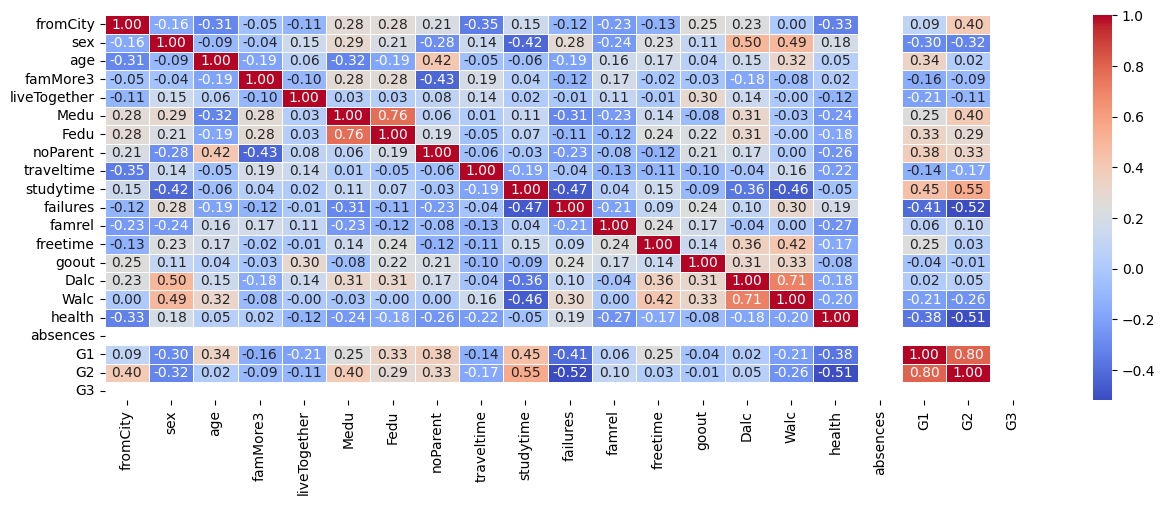

In [16]:
plt.figure(figsize=(15, 5))
sns.heatmap(data=only_no_g3.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.6)

### 시험 안본 사람은 drop한 사람임. 그래서 absences 기록이 사라짐 &rarr; 시험 안본 사람들 제거

In [17]:
print(df[df['G3'] == 0]['absences'].sum())

0


In [18]:
# 시험 안본 사람들 제거
df = df[df['G3'] > 0]

In [19]:
df.columns

Index(['school', 'fromCity', 'sex', 'age', 'famMore3', 'liveTogether', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'noParent', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

### 부모직업에 others가 많음. 
- 해당 특성이 유의미하다는게 밝혀져도 해석할 수 없다면 빼는게 맞다고 봄
- 부모직업에 따른 소득은 famsup(가족의 교육지원)과 paid(유로수업), schoolsup(학교지원) 특성으로도 유추가능하기에 불확실성이 큰 부모직업은 뺌

In [20]:
df['Mjob'].value_counts(), df['Fjob'].value_counts()

(Mjob
 other       127
 services     94
 teacher      54
 at_home      50
 health       32
 Name: count, dtype: int64,
 Fjob
 other       196
 services    100
 teacher      26
 health       18
 at_home      17
 Name: count, dtype: int64)

In [21]:
# 부모직업 제거
df = df.drop(columns=['Mjob', 'Fjob'])

In [22]:
df['reason'].value_counts()

reason
course        126
reputation     99
home           97
other          35
Name: count, dtype: int64

### 학교 다니는 이유는 course, reputation, home, other 이렇게 4개임. 이유별로 학생을 그룹화하고 그룹별로 3개 시험 평균값을 보면 차이가 없음. 즉, 성적 예측이 reasons는 의미가 없다 생각

In [23]:
reasons = df['reason'].unique()

for re in reasons:
    temp = df[df['reason'] == re]
    print((temp['G1'] + temp['G2'] + temp['G3']).mean() / 3)

11.166666666666666
11.285714285714285
11.357388316151203
11.72053872053872


##### 상위 25%, 하위 25%별 학교선택 이유를 보면 차이는 존재하나 매우 미미하고 표본도 적음. 일단 제거

In [24]:
above_q3 = df[df['G3'] >= df['G3'].quantile(0.75)]
low_q1 = df[df['G3'] <= df['G3'].quantile(0.25)]

print('성적 상위 25% 학생들 학교선택 이유')
for v, c in above_q3['reason'].value_counts().items():
    print(v, c, '\b%')
print('\n성적 하위 25% 학생들 학교선택 이유')
for v, c in low_q1['reason'].value_counts().items():
    print(v, c, '\b%')

성적 상위 25% 학생들 학교선택 이유
reputation 36%
course 30%
home 26%
other 8%

성적 하위 25% 학생들 학교선택 이유
course 37%
home 24%
reputation 23%
other 8%


In [25]:
# reason 컬럼 삭제
df = df.drop(columns=['reason'])

In [26]:
df.columns

Index(['school', 'fromCity', 'sex', 'age', 'famMore3', 'liveTogether', 'Medu',
       'Fedu', 'noParent', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [27]:
print(f'전체컬럼수: {len(df.columns)}')
print(f'숫자형 아닌 컬럼수: {len(df.select_dtypes(include=['object']).columns)}')
print(f'숫자형 컬럼수: {len(df.select_dtypes(include=['int']).columns)}')

전체컬럼수: 30
숫자형 아닌 컬럼수: 9
숫자형 컬럼수: 21


In [28]:
# Str타입으로 된 Yes/No값가진 컬럼들을 전부 0 or 1을 가진 int로 바꿈
not_num_cols = df.select_dtypes(include=['object']).columns

# 숫자형 아닌 컬럼들 표시
print(not_num_cols)

for col in not_num_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' or x == 'Yes' else 0)

Index(['school', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic'],
      dtype='object')


In [29]:
# 숫자형 아닌 컬럼들 없음 이제
df.select_dtypes(include=['object']).columns

Index([], dtype='object')

### 원랜 T/F는 bool타입으로 저장하려 했으나 csv 저장하고 다시 불러올 때 str타입으로 바뀌는 점 때문에 int형으로 유지함.
- str타입 아니게 불러오는 방법이 있으나 그럴거면 애초에 bool타입 아닌거로 저장하는게 편함

In [30]:
# # 0, 1로만 이루어진 컬럼, 즉 bool타입이어야 할 컬럼들을 bool로 변환
# for col in gp_df.columns:
#     if set(gp_df[col].unique()) <= {0, 1}:
#         gp_df[col] = gp_df[col].astype(bool)

### DecisionTreeRegressor, RandomForestRegressor, XGBoost, LightGBM 같은 트리계열 모델을 쓴다면 스케일링 필요없음. 

<Axes: >

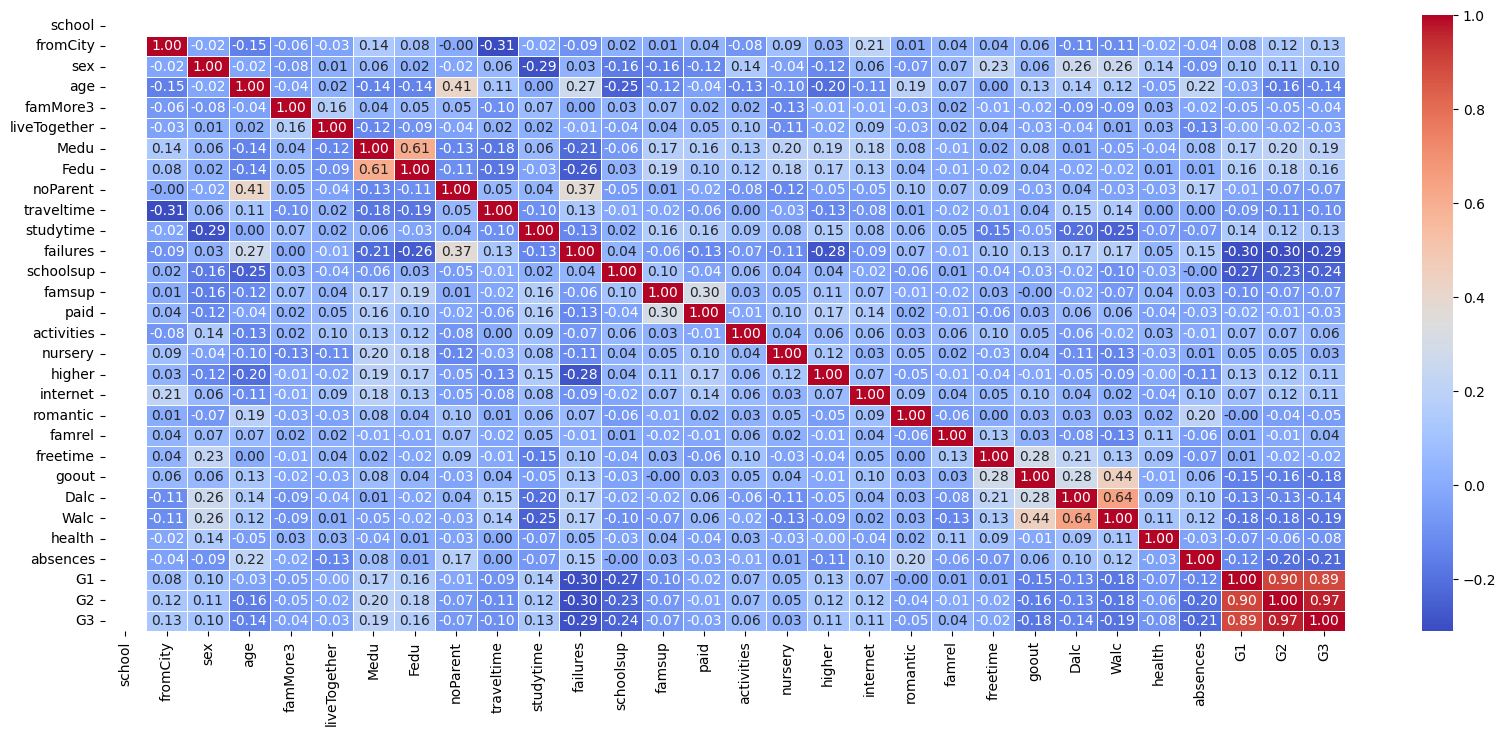

In [31]:
plt.figure(figsize=(20, 8))
sns.heatmap(data=df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.6)

### 스케일링 전 데이터프레임 저장하기

In [ ]:
df.to_csv('../data/before_scaling.csv', index=False)

### 점수만 정규분포로 만들기

Text(0.5, 1.0, 'Mean of Gs Distribution')

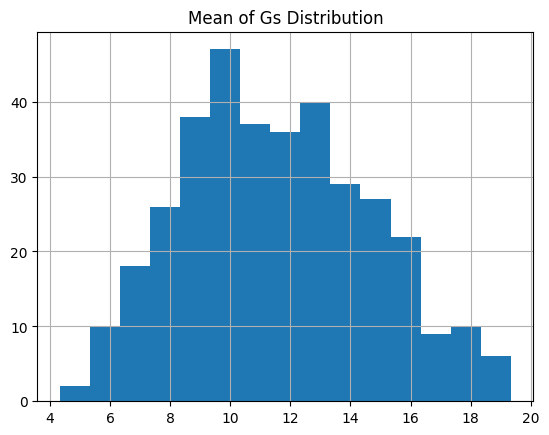

In [33]:
g_mean = ((df['G1'] + df['G2'] + df['G3']) / 3)
g_mean.hist(bins=15)
plt.title('Mean of Gs Distribution')

Text(0.5, 1.0, 'G3 Distribution')

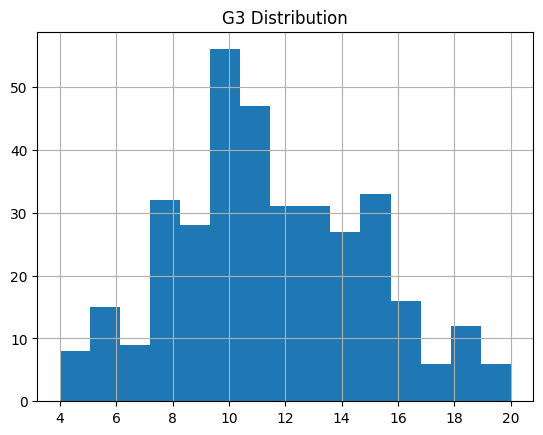

In [34]:
df['G3'].hist(bins=15)
plt.title('G3 Distribution')

## standard scaling 하기
### G3는 라벨로 쓸 것이기에 데이터 연관성 분석 때만 scaling하고 ML 단계에선 원래 값으로 바꿔야 함.

In [35]:
# scaling 하기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_Gs_df = pd.DataFrame()
scaled_Gs_df['G1'] = df['G1']
scaled_Gs_df['G2'] = df['G2']
scaled_Gs_df['G3'] = df['G3']

scaled_Gs_data = scaler.fit_transform(scaled_Gs_df)
scaled_Gs_df = pd.DataFrame(scaled_Gs_data, columns=scaled_Gs_df.columns)
scaled_df = df
scaled_df['G1'] = scaled_Gs_df['G1']
scaled_df['G2'] = scaled_Gs_df['G2']
scaled_df['G3'] = scaled_Gs_df['G3']

<Axes: >

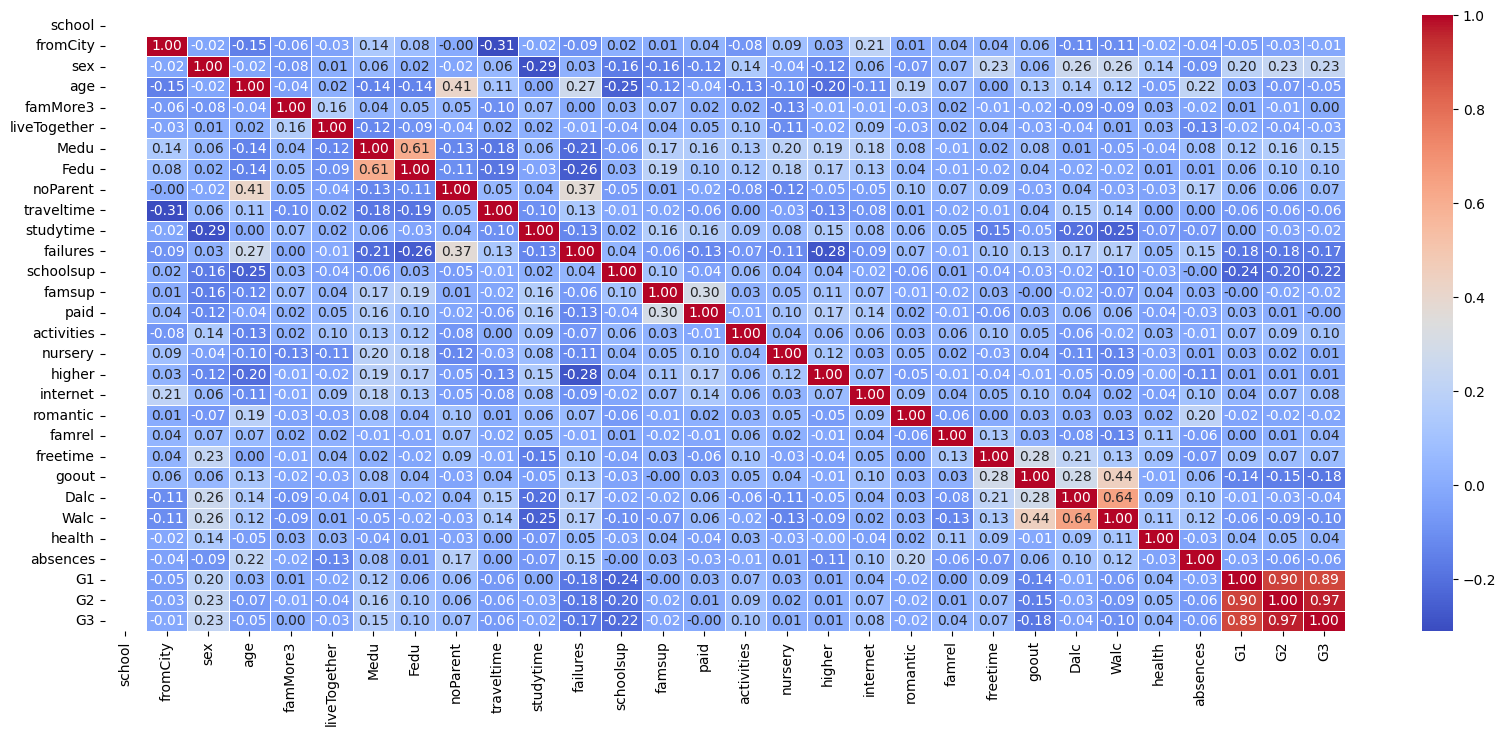

In [36]:
plt.figure(figsize=(20, 8))
sns.heatmap(data=scaled_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.6)

### Scaling 하고 난 후 csv로 저장

In [37]:
df.to_csv('after_scaling.csv', index=False)